In [29]:
from maap.maap import MAAP
maap = MAAP(maap_host='api.ops.maap-project.org')

# Launch DPS for 3.1.5_dps.py


In [30]:
from os import path
import os, glob
import datetime
import pandas as pd
import geopandas as gpd
!pip install xmltodict
import xmltodict

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


### Build the input list of granules - s3fs implementation


In [31]:
%%time
import s3fs
s3 = s3fs.S3FileSystem()
bucket = "s3://maap-ops-workspace"
searchkey_list = [f'nathanmthomas/dps_output/do_topo_stack_3-1-5_ubuntu/master/2021/10/**/*.tif' for DAY in ['03','04','05']]
# Concat list of lists to data frame
topo_path_df = pd.concat([pd.DataFrame(s3.glob(os.path.join(bucket, searchkey)), columns=['maap_path']) for searchkey in searchkey_list])

#Convert data frame to list
INPUT_TILE_NUM_LIST = [i.replace("maap-ops-workspace", "https://maap-ops-workspace.s3.amazonaws.com") for i in topo_path_df.maap_path.to_list()]
len(INPUT_TILE_NUM_LIST)

CPU times: user 51.7 ms, sys: 7.48 ms, total: 59.1 ms
Wall time: 1.26 s


0

### Get new tiles for version 3


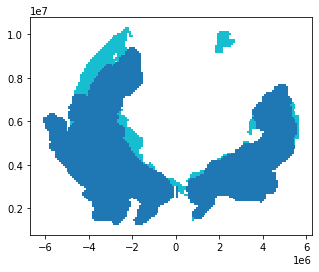

In [32]:
# Get all boreal tiles
boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg' #shared-buckets/nathanmthomas/boreal_grid_albers90k_gpkg.gpkg
boreal_tile_index = gpd.read_file(boreal_tile_index_path)

bad_tiles = [3540,3634,3728,3823,3916,4004] #Dropping the tiles near antimeridian that reproject poorly.
if True:
    # Remove bad tiles
    boreal_tile_index = boreal_tile_index[~boreal_tile_index['tile_num'].isin(bad_tiles)]

boreal_tile_index.plot(column='tile_version')
boreal_tile_index.groupby('tile_version')['tile_group'].agg(['count'])

INPUT_TILE_NUM_LIST = boreal_tile_index[boreal_tile_index.tile_version == 'version 2'].tile_num.to_list()

In [33]:
 len(INPUT_TILE_NUM_LIST)

639

In [34]:
TEST_DPS  = False

if TEST_DPS:
    print('Running DPS on a SUBSET list of input')
    DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST[-10:]
else:
    print('Running DPS on the FULL list of input')
    DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST
    
print(f"List length: {len(DPS_INPUT_TILE_NUM_LIST)}")

Running DPS on the FULL list of input
List length: 639


# Run a DPS of topo tiles

In [16]:
%%time
submit_results_df_list = []
len_input_list = len(DPS_INPUT_TILE_NUM_LIST)
print(f"# of input tiles for DPS: {len_input_list}")

for i, INPUT_TILE_NUM in enumerate(DPS_INPUT_TILE_NUM_LIST):

    DPS_num = i+1
    IDENTIFIER = 'do_topo_stack_3-1-5'
    ALGO_ID = f'{IDENTIFIER}_ubuntu'
    USER = 'lduncanson'
    WORKER_TYPE = 'maap-dps-worker-8gb'
    
    in_param_dict = {
                         'in_tile_fn': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/boreal_tiles_v003.gpkg',
                         'in_tile_num': INPUT_TILE_NUM,
                         'tile_buffer_m': 120,
                         'in_tile_layer': 'boreal_tiles_v003',
                         'topo_tile_fn': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/dem30m_tiles.geojson',
        }

    submit_result = maap.submitJob(
            identifier=IDENTIFIER,
            algo_id=ALGO_ID,
            version='master',
            username=USER, # username needs to be the same as whoever created the workspace
            queue=WORKER_TYPE,
            **in_param_dict
        )
    
    # Build a dataframe of submission details
    submit_result['dps_num'] = DPS_num
    submit_result['tile_num'] = INPUT_TILE_NUM
    submit_result['submit_time'] = datetime.datetime.now()
    submit_result['dbs_job_hour'] =datetime.datetime.now().hour
    submit_result['algo_id'] = ALGO_ID
    submit_result['user'] = USER
    submit_result['worker_type'] = WORKER_TYPE
    
    # Append to a list of data frames of submission results
    submit_results_df_list.append(pd.DataFrame([submit_result]))
    
    if DPS_num in [1, 100, 500, 1000, 1500, 2000, 3000, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000, 21000, 24000, len_input_list]:
        print(f"DPS run #: {DPS_num}\t| tile num: {INPUT_TILE_NUM}\t| submit status: {submit_result['status']}\t| job id: {submit_result['job_id']}") 
        
# Build a final submission results df and save
submit_results_df = pd.concat(submit_results_df_list)
nowtime = pd.Timestamp.now().strftime('%Y%m%d%H%M')
print(f"Current time:\t{nowtime}")
submit_results_df.to_csv(f'/projects/my-public-bucket/DPS_{IDENTIFIER}_submission_results_{len_input_list}_{nowtime}.csv')
submit_results_df

# of input tiles for DPS: 639
DPS run #: 1	| tile num: 22937	| submit status: success	| job id: 5bae5bee-b9cf-4b83-88ef-ef56e43ff4ce
DPS run #: 100	| tile num: 25181	| submit status: success	| job id: 89cd5948-0907-4f69-b193-10735e6985c7
DPS run #: 500	| tile num: 37073	| submit status: success	| job id: 736cbfa9-acad-4e2a-80f5-4205d1c7a818
DPS run #: 639	| tile num: 45970	| submit status: success	| job id: 9664acab-544b-4d81-a176-2f2853fb7687
Current time:	202203170207
CPU times: user 8.33 s, sys: 450 ms, total: 8.78 s
Wall time: 2min 36s


,status,http_status_code,job_id,dps_num,tile_num,submit_time,dbs_job_hour,algo_id,user,worker_type
0,success,200,5bae5bee-b9cf-4b83-88ef-ef56e43ff4ce,1,22937,2022-03-17 02:04:48.878334,2,do_topo_stack_3-1-5_ubuntu,lduncanson,maap-dps-worker-8gb
0,success,200,4d39d603-a01a-4844-8e5b-a9637f907c72,2,22938,2022-03-17 02:04:48.957912,2,do_topo_stack_3-1-5_ubuntu,lduncanson,maap-dps-worker-8gb
0,success,200,e30fc24d-4fa2-4432-9f15-8f68871995bc,3,23217,2022-03-17 02:04:49.077199,2,do_topo_stack_3-1-5_ubuntu,lduncanson,maap-dps-worker-8gb
0,success,200,f4d8dc61-e938-4182-baaa-d60f1503f638,4,23218,2022-03-17 02:04:49.308896,2,do_topo_stack_3-1-5_ubuntu,lduncanson,maap-dps-worker-8gb
0,success,200,f7e02d48-7cd3-453f-a062-4b00c7171905,5,23219,2022-03-17 02:04:49.559852,2,do_topo_stack_3-1-5_ubuntu,lduncanson,maap-dps-worker-8gb
...,...,...,...,...,...,...,...,...,...,...
0,success,200,aa7c8705-39a5-4037-a7be-17d01a1ccc47,635,42935,2022-03-17 02:07:23.518273,2,do_topo_stack_3-1-5_ubuntu,lduncanson,maap-dps-worker-8gb
0,success,200,9cf16cb0-8a27-4beb-81a4-5ecd9a510ea1,636,42936,2022-03-17 02:07:23.763953,2,do_topo_stack_3-1-5_ubuntu,lduncanson,maap-dps-worker-8gb
0,success,200,330f0e6c-ced2-40b2-af06-97fa9a64ed22,637,43326,2022-03-17 02:07:23.991507,2,do_topo_stack_3-1-5_ubuntu,lduncanson,maap-dps-worker-8gb
0,success,200,9615a4a5-7442-4666-8750-f5d763a9efe1,638,45716,2022-03-17 02:07:24.209125,2,do_topo_stack_3-1-5_ubuntu,lduncanson,maap-dps-worker-8gb


After almost any DPS job, you have to assess what succeeded and failed. This involves:
1. building a table of job status based on job ids captured in the job_results_df from the DPS run chunk (this takes 40 mins for ~47k jobs) --> this tells you how many jobs failed
2. merging the job status table with the job results df --> this tells you which specific granules (or tile nums) failed
3. building another input list of granules for a follow-up DPS
## Assess DPS results
Build a table of job status based on job id - how many jobs failed?

In [ ]:
%%time
def BUILD_TABLE_JOBSTATUS(submit_results_df):
    import xmltodict
    df = pd.concat([pd.DataFrame(xmltodict.parse(maap.getJobStatus(job_id).content)).transpose() for job_id in submit_results_df.job_id.to_list()])
    return df

job_status_df = BUILD_TABLE_JOBSTATUS(submit_results_df)
#print(job_status_df.head())

num_jobs = submit_results_df.shape[0]
z = submit_results_df.merge(job_status_df, how='left', left_on='job_id',  right_on='wps:JobID')

print(f'Count total jobs:\t{num_jobs}')
print(f"Count pending jobs:\t{z[z['wps:Status'] =='Accepted'].shape[0]}")
print(f"Count running jobs:\t{z[z['wps:Status'] =='Running'].shape[0]}")
print(f"Count succeeded jobs:\t{z[z['wps:Status'] =='Succeeded'].shape[0]}")
print(f"Count failed jobs:\t{z[z['wps:Status'] =='Failed'].shape[0]}")
print(f"% of failed jobs:\t{round(z[z['wps:Status'] =='Failed'].shape[0] / ( z[z['wps:Status'] =='Failed'].shape[0] + z[z['wps:Status'] =='Succeeded'].shape[0] ), 4) * 100}")

In [48]:
xmltodict.parse(maap.getJobResult(z[z['wps:Status'] =='Succeeded'].iloc[3].job_id).content)

OrderedDict([('wps:Result',
              OrderedDict([('@xmlns:ows', 'http://www.opengis.net/ows/2.0'),
                           ('@xmlns:schemaLocation',
                            'http://schemas.opengis.net/wps/2.0/wps.xsd'),
                           ('@xmlns:wps', 'http://www.opengis.net/wps/2.0'),
                           ('@xmlns:xsi',
                            'http://www.w3.org/2001/XMLSchema-instance'),
                           ('wps:JobID',
                            '442f4441-deaa-4799-bc1f-ad2622927da5'),
                           ('wps:Output',
                            OrderedDict([('@id',
                                          'output-2022-03-11T21:39:30.224518'),
                                         ('wps:Data',
                                          ['http://maap-ops-workspace.s3-website-us-west-2.amazonaws.com/lduncanson/dps_output/run_tile_atl08_ubuntu/master/2022/03/11/21/39/30/224518',
                                           's3://s3.us

In [25]:
xmltodict.parse(maap.getJobResult(z[z['wps:Status'] =='Failed'].iloc[0].job_id).content)

OrderedDict([('wps:Result',
              OrderedDict([('@xmlns:ows', 'http://www.opengis.net/ows/2.0'),
                           ('@xmlns:schemaLocation',
                            'http://schemas.opengis.net/wps/2.0/wps.xsd'),
                           ('@xmlns:wps', 'http://www.opengis.net/wps/2.0'),
                           ('@xmlns:xsi',
                            'http://www.w3.org/2001/XMLSchema-instance'),
                           ('wps:JobID',
                            '07bf62d3-6488-49ab-bbae-81b45f09bfda'),
                           ('wps:Output',
                            OrderedDict([('@id', 'traceback'),
                                         ('wps:Data',
                                          'activate does not accept more than one argument:\n[\'/app/icesat2_boreal/dps/alg_3-1-5/run.sh\', \'23551\', \'120\', \'boreal_tiles_v003\']\n\n+ /app/icesat2_boreal/dps/alg_3-1-5/run.sh 23551 120 boreal_tiles_v003\n+ unset PROJ_LIB\n+ mkdir output\n+++ dirname /

In [ ]:
!python $basedir/../../lib/tile_atl08.py